# Mesh properties for TOUGH3 (Part 2)

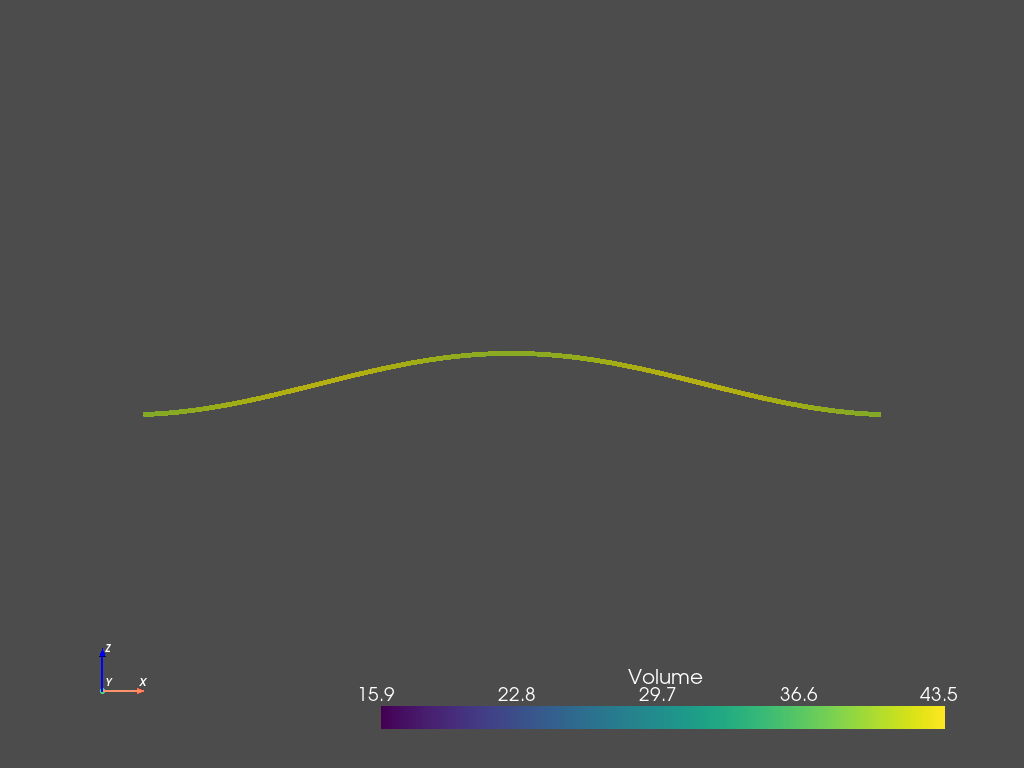

In [7]:
import pyvista as pv
import numpy as np

mesh = pv.read("./mesh/cos_.vtu")

cpos = [
    (6.18603515625, -23302.265175994733 , 42.33445739746094),
    (6.18603515625, 0.5, 42.33445739746094),
    (0.0, 0.0, 1.0),
]

pv.set_jupyter_backend('static')
mesh.plot(notebook=True, show_edges=False, cpos=cpos)

In order to set up a TOUGH simulation with this mesh, we need to supply further information: The initial condition, boundary conditions, materials as well as sinks and/or sources in the domain. 
For the initial condition and the materials we need to add cell data named "initial_conditions" and "material" to the mesh. Sinks and/or source require a dictionary (see below) and boundary conditions can be defined by changing the cell volumes or by defining material properties for the boundary cells.

Remark: We also need an INPUT file to set up a simulation. We do not discuss INPUT files here! INPUT files can be created manually (not recommended!) or [toughio](https://pypi.org/project/toughio/) or with [toughio-dash](https://toughio-dash.lbl.gov/).

Note, that the cell data "Volume" is calculated from `Voronoi()` and is used to define the TOUGH3 mesh. Changes in the `mesh["Volume"]` effects the cell volumes in the TOUGH3 mesh!

First we define initial conditions. For our model (TOUGH3 ECO2N) we need to define the inital salt saturation, the initial CO2 saturation as well as the initial reservoir pressure and the temperature. The required parameters and the order of the parameters are specified in the TOUGH3 manual for the selected module.

In [2]:
density = 1050.0
gravity = 9.81

SSalt = 0.05
SCO2 = 0.0
p0 = 29430000
T0 = 83

centers = mesh.cell_centers().points
incon = np.full((mesh.n_cells, 4), -1.0e9)
incon[:, 0] = p0 - density * gravity * centers[:, 2]
incon[:, 1] = SSalt
incon[:, 2] = SCO2
incon[:, 3] = T0
mesh.cell_data["initial_condition"] = incon

Now we define the boundary conditions. We want to have Dirichlet boundaries. To enforce that the initial conditions in the boundary cells did not change over time, we assign a large volume to the boundary cells.

In [3]:
# Define Boundary conditions
minx = -6000+20
maxx = 6000-20
ind = np.logical_or(centers[:,0] < minx,
                    centers[:,0] > maxx)
mesh["Volume"][ind] = mesh["Volume"][ind]*1000

Next, we define the materials for the reservoir. We assume homogeneous rock and define two types of materials respectivly regions: "SAND" and "WELL". 

For the "WELL" region, we define an injection well. "COM3" is CO2 and 0.06 the injection rate. "COM1" is water. We need to inject a small ammount of water to support numerical stability.

In [4]:
# Add materials
materials = {1: "SAND",
             2: "WELL"}

mesh.cell_data["material"] = 1
ind = mesh.find_cells_along_line([-3000, 0.5, -500], [-1500, 0.5, 500])
mesh.cell_data["material"][ind] = 2

# Define Sources
wells = {"WELL": {"COM3": 0.06,
                  "COM1": 1e-6}}

Now we have all information, we need write the MESH file and update the INFILE with the information on the wells. The injection rate is automatically distributed to all cells of the material 	proportional to the cell volumes.

We also save the mesh as VTU. After the simulation, the results can be attached to the VTU file and analyzed with Paraview.

In [5]:
from voromesh.tough3 import write_mesh, update_gener
from os.path import join

mesh.save(".\mesh\mesh_.vtu")

# Write TOUGH3 MESH file
path = r"./mesh/"
write_mesh(path, mesh, materials)

# Update TOUGH3 INFILE with information on wells
update_gener(join(path, "INFILE"), mesh, materials, wells)

100%


We need to select an efficient solver for this problem. For such a problem in TOUGH3 (3.0.0) GMRES with additive schwarz preconditioning from PETSc   

```
-ksp_type gmres
-pc_type asm
-sub_pc_type lu
-ksp_rtol 1e-8
```

or GMRES with ILU preconditioning from PETSc may be a good  choice:

```
-ksp_type gmres
-ksp_gmres_restart 30
-ksp_rtol 1e-8
-pc_type ilu
-pc_factor_mat_ordering_type natural
-pc_factor_reuse_factorization
-pc_factor_reuse_fill
-pc_factor_reuse_ordering
```

After the simulation, we can attach the results from TOUGH3 to the vtu mesh using `outfile2vtu()` from  `voromesh.tough3`. Open the generated pvd file in Paraview to see results with timestamps. 